In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve, recall_score, f1_score, precision_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as iPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve, recall_score, f1_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('./Data/draft0522.parquet')

In [3]:
model_df = df.drop(['school_name'],axis=1)

In [4]:
model_df.Round.value_counts(normalize=True)

0.0    0.358002
1.0    0.349761
2.0    0.292237
Name: Round, dtype: float64

In [5]:
X = model_df.drop(['Round'],axis=1)
y = model_df.Round

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team
player_age = X_test.Age

X_train.drop(['player','pick','year','team','Age'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team','Age'],axis=1,inplace=True)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes('float64')

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('impute',SimpleImputer(strategy='constant'))])

transformer = ColumnTransformer(transformers=[
    ('num', num_transformer, X_train_num.columns),
    ('cat', cat_transformer, X_train_cat.columns)])

pipe = Pipeline(steps=[
    ('trans',transformer),
    ('gaus',GaussianMixture(random_state=42))])

grid = {'gaus__n_components':[4,5,6,7,8,9,10]}

gridsearch = GridSearchCV(estimator=pipe,
                         param_grid=grid,
                         cv=5)

gridsearch.fit(X_train,y_train)

In [ ]:
gridsearch.best_estimator_

In [ ]:
preprocess = deepcopy(gridsearch.best_estimator_)

preprocess.steps.pop()

In [ ]:
X_transformed = preprocess.transform(X_train)

In [ ]:
gridsearch.best_estimator_[-1].aic(X_transformed)

In [ ]:
gridsearch.best_estimator_[-1].bic(X_transformed)

In [ ]:
y_pred = gridsearch.predict_proba(X_test)

In [ ]:
y_pred_df = pd.DataFrame(y_pred)

In [ ]:
tsne = TSNE(random_state=42,learning_rate=100)
tsne_y_pred = tsne.fit_transform(y_pred_df)
tsne_y_pred = pd.DataFrame(tsne_y_pred, columns = ['TSNE1','TSNE2'])

In [ ]:
tsne_y_pred['group'] = np.argmax(y_pred_df.values, axis = 1)

In [ ]:
tsne_x = transformer.fit_transform(X_test)
tsne_x = tsne.fit_transform(tsne_x)

In [ ]:
tsne_xs = pd.DataFrame(tsne_x, columns = ['TSNE1','TSNE2'])

In [ ]:
x_tsne = pd.concat([tsne_xs,tsne_y_pred['group']],axis=1)

In [ ]:
look = pd.concat([player_name.reset_index(),player_pick.reset_index(),player_team.reset_index(),player_year.reset_index(),y_test.reset_index(),X_test.reset_index(),tsne_y_pred.reset_index()],axis=1)

In [ ]:
relook = pd.concat([player_name.reset_index(),player_pick.reset_index(),player_team.reset_index(),player_year.reset_index(),y_test.reset_index(),X_test.reset_index(),x_tsne.reset_index()],axis=1)

In [ ]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=tsne_y_pred.TSNE1,y=tsne_y_pred.TSNE2, hue=tsne_y_pred['group'], palette = 'tab10',size=look.Round);

In [ ]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=x_tsne.TSNE1,y=x_tsne.TSNE2, hue=x_tsne['group'], palette = 'tab10',size=look.Round);

In [ ]:
relook.groupby('group').pos.value_counts()

In [ ]:
clump2_l = relook[(relook.TSNE2 < 15) & (relook.group == 2) & (relook.TSNE1 < -8)]

In [ ]:
clump2_l.pos.value_counts()

In [ ]:
clump1_lt = relook[(relook.TSNE2 < -15) & (relook.TSNE2 > -32) & (relook.group == 1) & (relook.TSNE1 < -5)]

In [ ]:
clump1_lt.pos.value_counts()

In [ ]:
clump1_rb = relook[(relook.TSNE2 < -12) & (relook.group == 1) & (relook.TSNE1 >= -5)]

In [ ]:
clump1_rb.pos.value_counts()

In [ ]:
clump0_b = relook[(relook.TSNE2 < 15) & (relook.group == 0)]

In [ ]:
clump0_b.pos.value_counts()

In [ ]:
clump0_t = relook[(relook.TSNE2 >= 15) & (relook.group == 0)]

In [ ]:
clump0_t.pos.value_counts()

In [ ]:
clump3_ml = relook[(relook.TSNE1 < -5) & (relook.TSNE2 > -20) & (relook.group == 3)]

In [ ]:
clump3_ml.pos.value_counts()

In [ ]:
clump3_bl = relook[(relook.TSNE1 < -20) & (relook.group == 3)]

In [ ]:
clump3_bl.pos.value_counts()

In [ ]:
clump3_r = relook[(relook.TSNE1 > -20) & (relook.group == 3)]

In [ ]:
clump3_r.pos.value_counts()

In [ ]:
clump3_bl.describe()

In [ ]:
pd.set_option("display.max_columns", None)
clump3_r.describe()

In [ ]:
look.groupby('group').mean()

In [ ]:
group0 = look[look.group == 0]
group1 = look[look.group == 1]
group2 = look[look.group == 2]
group3 = look[look.group == 3]

In [ ]:
group0.pos.value_counts(normalize=True)

In [ ]:
group1.pos.value_counts(normalize=True)

In [ ]:
group2.pos.value_counts(normalize=True)

In [ ]:
group3.pos.value_counts(normalize=True)

In [ ]:
look.groupby('group').tackles_total_season.mean()

In [ ]:
look.groupby('group').bench_reps.mean()

In [ ]:
look.groupby('group').weight.mean()

In [ ]:
look.groupby('group').height.mean()

In [ ]:
look.groupby('group').rec_career.mean()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team
player_age = X_test.Age

X_train.drop(['player','pick','year','team','Age'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team','Age'],axis=1,inplace=True)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes('float64')

smote = SMOTE(random_state=42)
over_samp = RandomOverSampler(random_state=42)
under_samp = RandomUnderSampler(random_state=42)

cat_transformer = iPipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = iPipeline(steps=[
    ('ss',StandardScaler()),
    ('impute',SimpleImputer(strategy='constant'))])

transformer = ColumnTransformer(transformers=[
    ('num', num_transformer, X_train_num.columns),
    ('cat', cat_transformer, X_train_cat.columns)])

tree_pipe = iPipeline(steps=([
    ('trans',transformer),
    ('smote',smote),
    ('over_samp',over_samp),
    ('under_samp',under_samp),
    ('tree',DecisionTreeClassifier(random_state=42))
]))

grid = {
    'tree__criterion':['gini','entropy','log_loss'],
    'tree__max_depth':[9,10,11],
    'tree__min_samples_split':[3],
    'tree__min_samples_leaf':[2]
}

gridsearch = GridSearchCV(estimator=tree_pipe,
                         param_grid=grid,
                         cv=5)

gridsearch.fit(X_train,y_train)

y_pred = gridsearch.predict(X_test)

gridsearch.best_params_

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

{'tree__criterion': 'entropy',
 'tree__max_depth': 9,
 'tree__min_samples_leaf': 2,
 'tree__min_samples_split': 3}

              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80       717
         1.0       0.54      0.45      0.49       695
         2.0       0.59      0.54      0.56       591

    accuracy                           0.63      2003
   macro avg       0.62      0.63      0.62      2003
weighted avg       0.62      0.63      0.62      2003



C:\Users\capta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


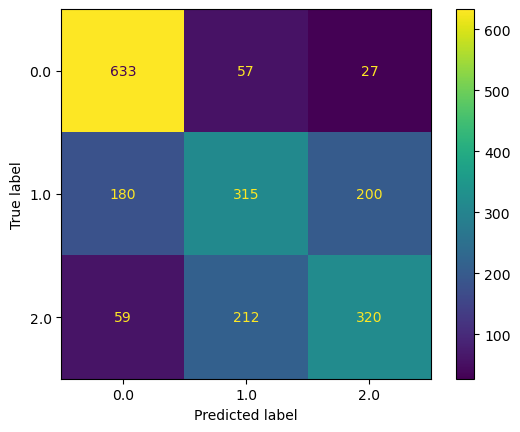

In [10]:
print(classification_report(y_test,y_pred))
plot_confusion_matrix(gridsearch,X_test,y_test)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team
player_age = X_test.Age

X_train.drop(['player','pick','year','team','Age'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team','Age'],axis=1,inplace=True)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes('float64')

smote = SMOTE(random_state=42)
over_samp = RandomOverSampler(random_state=42)
under_samp = RandomUnderSampler(random_state=42)

cat_transformer = iPipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = iPipeline(steps=[
    ('ss',StandardScaler()),
    ('impute',SimpleImputer(strategy='constant'))])

transformer = ColumnTransformer(transformers=[
    ('num', num_transformer, X_train_num.columns),
    ('cat', cat_transformer, X_train_cat.columns)])

rfc_pipe = iPipeline(steps=([
    ('trans',transformer),
#     ('smote',smote),
#     ('over_samp',over_samp),
#     ('under_samp',under_samp),
    ('sample',None),
    ('rfc',RandomForestClassifier(random_state=42))
]))

rfc_pipe.fit(X_train,y_train)

grid = {
    'rfc__criterion':['gini'],
    'rfc__max_depth':[None],
    'rfc__min_samples_split':[2],
    'rfc__min_samples_leaf':[2],
    'rfc__n_estimators':[78,80,82],
    'sample': [over_samp,smote]
    
}

gridsearch = GridSearchCV(estimator=rfc_pipe,
                         param_grid=grid,
                         cv=5)

gridsearch.fit(X_train,y_train)

y_pred = gridsearch.predict(X_test)

gridsearch.best_params_

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

{'rfc__criterion': 'gini',
 'rfc__max_depth': None,
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 2,
 'rfc__n_estimators': 80,
 'sample': SMOTE(random_state=42)}

In [65]:
len(y_pred)

2003

In [66]:
results = pd.concat([player_year.reset_index(),player_pick.reset_index(),player_name.reset_index(),y_test.reset_index(),pd.Series(y_pred),X_test.reset_index()],axis=1).sort_values(by=['year','pick'],ascending=[False,True])

In [113]:
not_udfa.pos.value_counts()

RB      16
WR      15
OL      11
S       10
LB      10
DE       6
TE       4
FB       4
DT       3
CB       2
DL       1
EDGE     1
QB       1
Name: pos, dtype: int64

In [142]:
not_top = results[(results.Round==1)&(results[0]==2)]
not_top

,index,year,index,pick,index,player,index,Round,0,index,pos,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,def_int_season,def_int_yds_season,def_int_yds_per_int_season,def_int_career,def_int_yds_career,def_int_yds_per_int_career,pass_cmp_season,pass_att_season,pass_cmp_pct_season,pass_yds_season,pass_yds_per_att_season,adj_pass_yds_per_att_season,pass_td_season,pass_int_season,pass_rating_season,pass_cmp_career,pass_att_career,pass_cmp_pct_career,pass_yds_career,pass_yds_per_att_career,adj_pass_yds_per_att_career,pass_td_career,pass_int_career,pass_rating_career,rush_att_season,rush_yds_season,rush_yds_per_att_season,rush_td_season,rec_season,rec_yds_season,rec_yds_per_rec_season,scrim_att_season,scrim_yds_season,scrim_yds_per_att_season,scrim_td_season,rush_att_career,rush_yds_career,rush_yds_per_att_career,rush_td_career,rec_career,rec_yds_career,rec_yds_per_rec_career,rec_td_career,scrim_att_career,scrim_yds_career,scrim_yds_per_att_career,scrim_td_career,fumbles_rec_yds_career,fumbles_rec_td_career,rec_td_season,def_int_td_season,def_int_td_career,fumbles_rec_career,fumbles_rec_yds_season,fumbles_rec_td_season,fumbles_rec_season,tackles_solo_season,tackles_assists_season,tackles_total_season,tackles_loss_season,sacks_season,pass_defended_season,tackles_solo_career,tackles_assists_career,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,college_conference,speed,shuttle_agility,cone_agility
879,5778,2022.0,5778,109.0,5778,Coby Bryant,5778,1.0,2.0,5778,CB,73.0,193.0,4.54,NaN,17.0,NaN,NaN,NaN,14.0,2.0,21.0,10.5,9.0,46.0,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,34.0,10.0,44.0,1.5,NaN,11.0,134.0,36.0,170.0,5.0,NaN,35.0,2.0,4.0,American Athletic Conference,90.858151,NaN,NaN
1971,5752,2022.0,5752,119.0,5752,Jalyn Armour-Davis,5752,1.0,2.0,5752,CB,73.0,197.0,4.39,34.5,14.0,NaN,NaN,NaN,11.0,3.0,51.0,17.0,3.0,51.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,10.0,32.0,1.0,NaN,4.0,22.0,13.0,35.0,1.0,NaN,6.0,NaN,NaN,Southeastern Conference,106.081131,NaN,NaN
77,6045,2022.0,6045,122.0,6045,Zamir White,6045,1.0,2.0,6045,RB,72.0,214.0,4.40,33.5,NaN,128.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,856.0,5.4,11.0,9.0,75.0,8.3,169.0,931.0,5.5,11.0,382.0,2043.0,5.3,25.0,17.0,132.0,7.8,NaN,399.0,2175.0,5.5,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Southeastern Conference,114.191312,NaN,NaN
518,5754,2022.0,5754,138.0,5754,Calvin Austin,5754,1.0,2.0,5754,WR,68.0,170.0,4.32,39.0,NaN,135.0,6.65,4.07,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,69.0,69.0,1.0,74.0,1149.0,15.5,75.0,1218.0,16.2,9.0,8.0,169.0,21.1,3.0,156.0,2541.0,16.3,22.0,164.0,2710.0,16.5,25.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,American Athletic Conference,97.621152,123.908552,115.614946
1963,6023,2022.0,6023,140.0,6023,Zach Tom,6023,1.0,2.0,6023,OL,76.0,304.0,4.94,33.0,NaN,118.0,7.32,4.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,102.092957,152.290736,155.013791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [144]:
not_top[not_top.pos == 'WR']

,index,year,index,pick,index,player,index,Round,0,index,pos,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,def_int_season,def_int_yds_season,def_int_yds_per_int_season,def_int_career,def_int_yds_career,def_int_yds_per_int_career,pass_cmp_season,pass_att_season,pass_cmp_pct_season,pass_yds_season,pass_yds_per_att_season,adj_pass_yds_per_att_season,pass_td_season,pass_int_season,pass_rating_season,pass_cmp_career,pass_att_career,pass_cmp_pct_career,pass_yds_career,pass_yds_per_att_career,adj_pass_yds_per_att_career,pass_td_career,pass_int_career,pass_rating_career,rush_att_season,rush_yds_season,rush_yds_per_att_season,rush_td_season,rec_season,rec_yds_season,rec_yds_per_rec_season,scrim_att_season,scrim_yds_season,scrim_yds_per_att_season,scrim_td_season,rush_att_career,rush_yds_career,rush_yds_per_att_career,rush_td_career,rec_career,rec_yds_career,rec_yds_per_rec_career,rec_td_career,scrim_att_career,scrim_yds_career,scrim_yds_per_att_career,scrim_td_career,fumbles_rec_yds_career,fumbles_rec_td_career,rec_td_season,def_int_td_season,def_int_td_career,fumbles_rec_career,fumbles_rec_yds_season,fumbles_rec_td_season,fumbles_rec_season,tackles_solo_season,tackles_assists_season,tackles_total_season,tackles_loss_season,sacks_season,pass_defended_season,tackles_solo_career,tackles_assists_career,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,college_conference,speed,shuttle_agility,cone_agility
518,5754,2022.0,5754,138.0,5754,Calvin Austin,5754,1.0,2.0,5754,WR,68.0,170.0,4.32,39.0,NaN,135.0,6.65,4.07,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,69.0,69.0,1.0,74.0,1149.0,15.5,75.0,1218.0,16.2,9.0,8.0,169.0,21.1,3.0,156.0,2541.0,16.3,22.0,164.0,2710.0,16.5,25.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,American Athletic Conference,97.621152,123.908552,115.614946
1541,5933,2022.0,5933,229.0,5933,Bo Melton,5933,1.0,2.0,5933,WR,71.0,189.0,4.34,38.0,NaN,121.0,6.98,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,51.0,5.7,NaN,55.0,618.0,11.2,64.0,669.0,10.5,3.0,25.0,165.0,6.6,2.0,164.0,2011.0,12.3,11.0,189.0,2176.0,11.5,13.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Big Ten Conference,106.544953,NaN,111.154112
1867,5113,2020.0,5113,161.0,5113,Tyler Johnson,5113,1.0,2.0,5113,WR,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,-1.0,NaN,86.0,1318.0,15.3,87.0,1317.0,15.1,13.0,1.0,-1.0,-1.0,NaN,213.0,3305.0,15.5,33.0,214.0,3304.0,15.4,33.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Big Ten Conference,NaN,NaN,NaN
49,4660,2019.0,4660,103.0,4660,Hakeem Butler,4660,1.0,2.0,4660,WR,77.0,227.0,4.48,36.0,18.0,128.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,1318.0,22.0,60.0,1318.0,22.0,9.0,NaN,NaN,NaN,NaN,110.0,2149.0,19.5,18.0,110.0,2149.0,19.5,18.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,112.705159,NaN,NaN
1424,4310,2018.0,4310,191.0,4310,Dylan Cantrell,4310,1.0,2.0,4310,WR,75.0,226.0,4.59,38.5,18.0,130.0,6.56,4.03,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,3.0,1.0,71.0,816.0,11.5,72.0,819.0,11.4,8.0,1.0,3.0,3.0,1.0,158.0,1873.0,11.9,18.0,159.0,1876.0,11.8,19.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,101.832802,171.363471,160.113119
1215,4248,2017.0,4248,110.0,4248,Dede Westbrook,4248,1.0,2.0,4248,WR,72.0,178.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [143]:
not_top.pos.value_counts()

WR      31
LB      27
CB      24
OL      24
S       20
DE      19
RB      17
QB      11
DT       8
DL       6
TE       6
EDGE     5
DB       1
FB       1
Name: pos, dtype: int64

In [70]:
not_udfa = results[(results.Round==0)&(results[0]!=0)]

udfa = results[(results.Round!=0)&(results[0]==0)]

In [138]:
school = df[['school_name','player']]

In [139]:
names = not_udfa.merge(school,on='player')

In [141]:
names[names.pos == 'S']

,index,year,index,pick,index,player,index,Round,0,index,pos,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,def_int_season,def_int_yds_season,def_int_yds_per_int_season,def_int_career,def_int_yds_career,def_int_yds_per_int_career,pass_cmp_season,pass_att_season,pass_cmp_pct_season,pass_yds_season,pass_yds_per_att_season,adj_pass_yds_per_att_season,pass_td_season,pass_int_season,pass_rating_season,pass_cmp_career,pass_att_career,pass_cmp_pct_career,pass_yds_career,pass_yds_per_att_career,adj_pass_yds_per_att_career,pass_td_career,pass_int_career,pass_rating_career,rush_att_season,rush_yds_season,rush_yds_per_att_season,rush_td_season,rec_season,rec_yds_season,rec_yds_per_rec_season,scrim_att_season,scrim_yds_season,scrim_yds_per_att_season,scrim_td_season,rush_att_career,rush_yds_career,rush_yds_per_att_career,rush_td_career,rec_career,rec_yds_career,rec_yds_per_rec_career,rec_td_career,scrim_att_career,scrim_yds_career,scrim_yds_per_att_career,scrim_td_career,fumbles_rec_yds_career,fumbles_rec_td_career,rec_td_season,def_int_td_season,def_int_td_career,fumbles_rec_career,fumbles_rec_yds_season,fumbles_rec_td_season,fumbles_rec_season,tackles_solo_season,tackles_assists_season,tackles_total_season,tackles_loss_season,sacks_season,pass_defended_season,tackles_solo_career,tackles_assists_career,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,college_conference,speed,shuttle_agility,cone_agility,school_name
0,5937,2022.0,5937,NaN,5937,Smoke Monday,5937,0.0,2.0,5937,S,74.0,207.0,4.52,NaN,NaN,124.0,7.00,NaN,13.0,1.0,36.0,36.0,5.0,196.0,39.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,44.0,19.0,63.0,9.0,2.0,5.0,105.0,66.0,171.0,17.0,6.0,8.0,NaN,1.0,None,99.185138,NaN,120.699708,Auburn
12,3661,2016.0,3661,NaN,3661,Jeremy Cash,3661,0.0,1.0,3661,S,72.0,212.0,4.56,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,6.0,56.0,9.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1.0,57.0,43.0,100.0,18.0,2.5,4.0,189.0,143.0,332.0,38.0,8.0,14.0,3.0,9.0,None,98.063296,NaN,NaN,Duke
36,2552,2012.0,2552,NaN,2552,Trenton Robinson,2552,0.0,2.0,2552,S,70.0,195.0,4.46,35.0,15.0,125.0,NaN,4.15,14.0,4.0,40.0,10.0,9.0,59.0,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,32.0,80.0,2.0,NaN,2.0,122.0,107.0,229.0,2.0,NaN,10.0,NaN,NaN,None,98.565555,131.483792,NaN,Michigan State
39,2117,2011.0,2117,NaN,2117,Jeron Johnson,2117,0.0,1.0,2117,S,70.0,212.0,4.51,NaN,23.0,NaN,NaN,NaN,13.0,1.0,NaN,NaN,8.0,53.0,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,37.0,82.0,1.0,NaN,NaN,194.0,134.0,328.0,12.0,1.5,6.0,NaN,1.0,None,102.484855,NaN,NaN,Boise State
41,2135,2011.0,2135,NaN,2135,Joe Lefeged,2135,0.0,2.0,2135,S,72.0,210.0,4.42,36.5,18.0,122.0,6.82,4.13,12.0,1.0,29.0,29.0,2.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,46.0,38.0,84.0,3.5,1.5,NaN,141.0,97.0,238.0,13.5,7.0,5.0,NaN,2.0,None,110.042440,144.360735,132.402494,Rutgers
46,1699,2010.0,1699,NaN,1699,Barry Church,1699,0.0,1.0,1699,S,73.0,222.0,4.69,36.0,19.0,121.0,6.65,4.17,12.0,1.0,4.0,4.0,9.0,170.0,18.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [137]:
not_udfa[not_udfa.pos == 'S']

,index,year,index,pick,index,player,index,Round,0,index,pos,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,def_int_season,def_int_yds_season,def_int_yds_per_int_season,def_int_career,def_int_yds_career,def_int_yds_per_int_career,pass_cmp_season,pass_att_season,pass_cmp_pct_season,pass_yds_season,pass_yds_per_att_season,adj_pass_yds_per_att_season,pass_td_season,pass_int_season,pass_rating_season,pass_cmp_career,pass_att_career,pass_cmp_pct_career,pass_yds_career,pass_yds_per_att_career,adj_pass_yds_per_att_career,pass_td_career,pass_int_career,pass_rating_career,rush_att_season,rush_yds_season,rush_yds_per_att_season,rush_td_season,rec_season,rec_yds_season,rec_yds_per_rec_season,scrim_att_season,scrim_yds_season,scrim_yds_per_att_season,scrim_td_season,rush_att_career,rush_yds_career,rush_yds_per_att_career,rush_td_career,rec_career,rec_yds_career,rec_yds_per_rec_career,rec_td_career,scrim_att_career,scrim_yds_career,scrim_yds_per_att_career,scrim_td_career,fumbles_rec_yds_career,fumbles_rec_td_career,rec_td_season,def_int_td_season,def_int_td_career,fumbles_rec_career,fumbles_rec_yds_season,fumbles_rec_td_season,fumbles_rec_season,tackles_solo_season,tackles_assists_season,tackles_total_season,tackles_loss_season,sacks_season,pass_defended_season,tackles_solo_career,tackles_assists_career,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,college_conference,speed,shuttle_agility,cone_agility
174,5937,2022.0,5937,NaN,5937,Smoke Monday,5937,0.0,2.0,5937,S,74.0,207.0,4.52,NaN,NaN,124.0,7.00,NaN,13.0,1.0,36.0,36.0,5.0,196.0,39.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,44.0,19.0,63.0,9.0,2.0,5.0,105.0,66.0,171.0,17.0,6.0,8.0,NaN,1.0,None,99.185138,NaN,120.699708
602,3661,2016.0,3661,NaN,3661,Jeremy Cash,3661,0.0,1.0,3661,S,72.0,212.0,4.56,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,6.0,56.0,9.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1.0,57.0,43.0,100.0,18.0,2.5,4.0,189.0,143.0,332.0,38.0,8.0,14.0,3.0,9.0,None,98.063296,NaN,NaN
1548,2552,2012.0,2552,NaN,2552,Trenton Robinson,2552,0.0,2.0,2552,S,70.0,195.0,4.46,35.0,15.0,125.0,NaN,4.15,14.0,4.0,40.0,10.0,9.0,59.0,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,32.0,80.0,2.0,NaN,2.0,122.0,107.0,229.0,2.0,NaN,10.0,NaN,NaN,None,98.565555,131.483792,NaN
126,2117,2011.0,2117,NaN,2117,Jeron Johnson,2117,0.0,1.0,2117,S,70.0,212.0,4.51,NaN,23.0,NaN,NaN,NaN,13.0,1.0,NaN,NaN,8.0,53.0,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,37.0,82.0,1.0,NaN,NaN,194.0,134.0,328.0,12.0,1.5,6.0,NaN,1.0,None,102.484855,NaN,NaN
816,2135,2011.0,2135,NaN,2135,Joe Lefeged,2135,0.0,2.0,2135,S,72.0,210.0,4.42,36.5,18.0,122.0,6.82,4.13,12.0,1.0,29.0,29.0,2.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,46.0,38.0,84.0,3.5,1.5,NaN,141.0,97.0,238.0,13.5,7.0,5.0,NaN,2.0,None,110.042440,144.360735,132.402494
154,1699,2010.0,1699,NaN,1699,Barry Church,1699,0.0,1.0,1699,S,73.0,222.0,4.69,36.0,19.0,121.0,6.65,4.17,12.0,1.0,4.0,4.0,9.0,170.0,18.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN

In [129]:
nudfa = pd.DataFrame((not_udfa.pos.value_counts() / model_df.pos.value_counts())*100).sort_values(by='pos',ascending=False)
nudfa

,pos
FB,5.194805
RB,2.979516
S,2.288330
WR,1.775148
DE,1.558442
EDGE,1.538462
LB,1.436782
TE,1.208459
OL,1.128205
DL,0.840336


In [117]:
udfa.pos.value_counts()

OL    56
WR    49
LB    27
DT    25
RB    22
CB    18
DE    10
S      9
QB     7
TE     6
FB     4
P      4
K      2
Name: pos, dtype: int64

In [133]:
posudfa = pd.DataFrame((udfa.pos.value_counts() / model_df.pos.value_counts())*100).sort_values(by='pos',ascending=False)
posudfa

,pos
DT,6.684492
WR,5.798817
OL,5.743590
FB,5.194805
RB,4.096834
LB,3.879310
P,3.669725
CB,2.936378
DE,2.597403
K,2.469136


In [100]:
udfa[udfa.pos == 'WR'].describe()

,index,year,index,pick,index,index,Round,0,index,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,def_int_season,def_int_yds_season,def_int_yds_per_int_season,def_int_career,def_int_yds_career,def_int_yds_per_int_career,pass_cmp_season,pass_att_season,pass_cmp_pct_season,pass_yds_season,pass_yds_per_att_season,adj_pass_yds_per_att_season,pass_td_season,pass_int_season,pass_rating_season,pass_cmp_career,pass_att_career,pass_cmp_pct_career,pass_yds_career,pass_yds_per_att_career,adj_pass_yds_per_att_career,pass_td_career,pass_int_career,pass_rating_career,rush_att_season,rush_yds_season,rush_yds_per_att_season,rush_td_season,rec_season,rec_yds_season,rec_yds_per_rec_season,scrim_att_season,scrim_yds_season,scrim_yds_per_att_season,scrim_td_season,rush_att_career,rush_yds_career,rush_yds_per_att_career,rush_td_career,rec_career,rec_yds_career,rec_yds_per_rec_career,rec_td_career,scrim_att_career,scrim_yds_career,scrim_yds_per_att_career,scrim_td_career,fumbles_rec_yds_career,fumbles_rec_td_career,rec_td_season,def_int_td_season,def_int_td_career,fumbles_rec_career,fumbles_rec_yds_season,fumbles_rec_td_season,fumbles_rec_season,tackles_solo_season,tackles_assists_season,tackles_total_season,tackles_loss_season,sacks_season,pass_defended_season,tackles_solo_career,tackles_assists_career,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,speed,shuttle_agility,cone_agility
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.0,49.000000,49.000000,49.000000,49.000000,42.000000,23.000000,41.000000,34.000000,37.000000,42.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.000000,28.000000,28.000000,10.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,39.000000,36.000000,36.000000,36.000000,14.000000,42.000000,42.000000,42.000000,41.000000,42.000000,42.000000,42.000000,42.000000,0.0,0.0,38.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.000000,37.000000,34.000000
mean,1309.979592,2008.510204,1309.979592,159.938776,1309.979592,1309.979592,1.204082,0.0,1309.979592,72.836735,201.448980,4.493673,35.857143,14.434783,121.365854,6.910588,4.259189,12.071429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.571429,52.357143,4.614286,1.400000,51.619048,742.166667,14.709524,57.333333,777.071429,14.111905,6.923077,21.222222,124.583333,5.241667,2.285714,139.571429,2016.142857,14.678571,15.487805,157.761905,2122.928571,14.061905,15.880952,NaN,NaN,6.736842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.925821,123.123176,120.739078
std,787.642672,2.398979,787.642672,63.865552,787.642672,787.642672,0.407206,0.0,787.642672,2.435390,15.168582,0.085992,2.578726,4.175971,5.161183,0.213072,0.163170,1.420973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.840352,75.022572,5.771880,0.699206,20.126372,269.973433,3.366826,23.945738,272.070686,3.595743,3.382498,33.276428,202.816648,5.967358,1.637473,52.264871,710.614560,2.343287,7.450241,66.135784,713.790616,2.771805,7.740304,NaN,NaN,3.072847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.112362,19.518999,13.112229
min,75.000000,2005.000000,75.000000,45.000000,75.000000,75.000000,1.000000,0.0,75.000000,65.000000,163.000000,4.310000,28.500000,7.000000,114.000000,6.500000,3.980000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-7.000000,-7.000000,1.000000,3.000000,36.000000,8.400000,21.000000,162.000000,5.400000,1.000000,1.000000,-25.000000,-12.500000,1.000000,7.000000,72.000000,10.200000,4.000000,54.000000,848.000000,7.000000,4.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.390695,82.418751,101

In [90]:
pd.set_option("display.max_columns", None)

not_udfa[not_udfa.pos == 'S']

,index,year,index,pick,index,player,index,Round,0,index,pos,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,def_int_season,def_int_yds_season,def_int_yds_per_int_season,def_int_career,def_int_yds_career,def_int_yds_per_int_career,pass_cmp_season,pass_att_season,pass_cmp_pct_season,pass_yds_season,pass_yds_per_att_season,adj_pass_yds_per_att_season,pass_td_season,pass_int_season,pass_rating_season,pass_cmp_career,pass_att_career,pass_cmp_pct_career,pass_yds_career,pass_yds_per_att_career,adj_pass_yds_per_att_career,pass_td_career,pass_int_career,pass_rating_career,rush_att_season,rush_yds_season,rush_yds_per_att_season,rush_td_season,rec_season,rec_yds_season,rec_yds_per_rec_season,scrim_att_season,scrim_yds_season,scrim_yds_per_att_season,scrim_td_season,rush_att_career,rush_yds_career,rush_yds_per_att_career,rush_td_career,rec_career,rec_yds_career,rec_yds_per_rec_career,rec_td_career,scrim_att_career,scrim_yds_career,scrim_yds_per_att_career,scrim_td_career,fumbles_rec_yds_career,fumbles_rec_td_career,rec_td_season,def_int_td_season,def_int_td_career,fumbles_rec_career,fumbles_rec_yds_season,fumbles_rec_td_season,fumbles_rec_season,tackles_solo_season,tackles_assists_season,tackles_total_season,tackles_loss_season,sacks_season,pass_defended_season,tackles_solo_career,tackles_assists_career,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,college_conference,speed,shuttle_agility,cone_agility
174,5937,2022.0,5937,NaN,5937,Smoke Monday,5937,0.0,2.0,5937,S,74.0,207.0,4.52,NaN,NaN,124.0,7.00,NaN,13.0,1.0,36.0,36.0,5.0,196.0,39.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,44.0,19.0,63.0,9.0,2.0,5.0,105.0,66.0,171.0,17.0,6.0,8.0,NaN,1.0,None,99.185138,NaN,120.699708
602,3661,2016.0,3661,NaN,3661,Jeremy Cash,3661,0.0,1.0,3661,S,72.0,212.0,4.56,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,6.0,56.0,9.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1.0,57.0,43.0,100.0,18.0,2.5,4.0,189.0,143.0,332.0,38.0,8.0,14.0,3.0,9.0,None,98.063296,NaN,NaN
1548,2552,2012.0,2552,NaN,2552,Trenton Robinson,2552,0.0,2.0,2552,S,70.0,195.0,4.46,35.0,15.0,125.0,NaN,4.15,14.0,4.0,40.0,10.0,9.0,59.0,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,32.0,80.0,2.0,NaN,2.0,122.0,107.0,229.0,2.0,NaN,10.0,NaN,NaN,None,98.565555,131.483792,NaN
126,2117,2011.0,2117,NaN,2117,Jeron Johnson,2117,0.0,1.0,2117,S,70.0,212.0,4.51,NaN,23.0,NaN,NaN,NaN,13.0,1.0,NaN,NaN,8.0,53.0,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,37.0,82.0,1.0,NaN,NaN,194.0,134.0,328.0,12.0,1.5,6.0,NaN,1.0,None,102.484855,NaN,NaN
816,2135,2011.0,2135,NaN,2135,Joe Lefeged,2135,0.0,2.0,2135,S,72.0,210.0,4.42,36.5,18.0,122.0,6.82,4.13,12.0,1.0,29.0,29.0,2.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,46.0,38.0,84.0,3.5,1.5,NaN,141.0,97.0,238.0,13.5,7.0,5.0,NaN,2.0,None,110.042440,144.360735,132.402494
154,1699,2010.0,1699,NaN,1699,Barry Church,1699,0.0,1.0,1699,S,73.0,222.0,4.69,36.0,19.0,121.0,6.65,4.17,12.0,1.0,4.0,4.0,9.0,170.0,18.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN

In [50]:
rfc_pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

array(['x0_DB', 'x0_DE', 'x0_DL', 'x0_DT', 'x0_EDGE', 'x0_FB', 'x0_K',
       'x0_LB', 'x0_LS', 'x0_OL', 'x0_P', 'x0_QB', 'x0_RB', 'x0_S',
       'x0_TE', 'x0_WR', 'x1_Atlantic Coast Conference', 'x1_Big East',
       'x1_Big Sky Conference', 'x1_Big South Conference',
       'x1_Big Ten Conference', 'x1_Big Twelve Conference',
       'x1_Central Intercollegiate Athletic Association',
       'x1_Colonial Athletic Association', 'x1_Conference USA',
       'x1_Great American Conference',
       'x1_Great Lakes Intercollegiate Athletic Conference',
       'x1_Great Northwest Athletic Conference',
       'x1_Gulf South Conference', 'x1_Independent', 'x1_Ivy League',
       'x1_Liberty League', 'x1_Lone Star Conference',
       'x1_Mid-America Intercollegiate Athletic Association',
       'x1_Mid-American Conference', 'x1_Mid-Eastern Athletic Conference',
       'x1_Minnesota Intercollegiate Athletic Conference',
       'x1_Missouri Valley Football Conference',
       'x1_Mountain East Conf

In [54]:
feature_names = ['x0_DB', 'x0_DE', 'x0_DL', 'x0_DT', 'x0_EDGE', 'x0_FB', 'x0_K',
       'x0_LB', 'x0_LS', 'x0_OL', 'x0_P', 'x0_QB', 'x0_RB', 'x0_S',
       'x0_TE', 'x0_WR', 'height', 'weight', 'forty_yd', 'vertical', 'bench_reps', 'broad_jump',
       'cone', 'shuttle', 'g_season', 'def_int_season', 'def_int_yds_season',
       'def_int_yds_per_int_season', 'def_int_career', 'def_int_yds_career',
       'def_int_yds_per_int_career', 'pass_cmp_season', 'pass_att_season',
       'pass_cmp_pct_season', 'pass_yds_season', 'pass_yds_per_att_season',
       'adj_pass_yds_per_att_season', 'pass_td_season', 'pass_int_season',
       'pass_rating_season', 'pass_cmp_career', 'pass_att_career',
       'pass_cmp_pct_career', 'pass_yds_career', 'pass_yds_per_att_career',
       'adj_pass_yds_per_att_career', 'pass_td_career', 'pass_int_career',
       'pass_rating_career', 'rush_att_season', 'rush_yds_season',
       'rush_yds_per_att_season', 'rush_td_season', 'rec_season',
       'rec_yds_season', 'rec_yds_per_rec_season', 'scrim_att_season',
       'scrim_yds_season', 'scrim_yds_per_att_season', 'scrim_td_season',
       'rush_att_career', 'rush_yds_career', 'rush_yds_per_att_career',
       'rush_td_career', 'rec_career', 'rec_yds_career',
       'rec_yds_per_rec_career', 'rec_td_career', 'scrim_att_career',
       'scrim_yds_career', 'scrim_yds_per_att_career', 'scrim_td_career',
       'fumbles_rec_yds_career', 'fumbles_rec_td_career', 'rec_td_season',
       'def_int_td_season', 'def_int_td_career', 'fumbles_rec_career',
       'fumbles_rec_yds_season', 'fumbles_rec_td_season', 'fumbles_rec_season',
       'tackles_solo_season', 'tackles_assists_season', 'tackles_total_season',
       'tackles_loss_season', 'sacks_season', 'pass_defended_season',
       'tackles_solo_career', 'tackles_assists_career', 'tackles_total_career',
       'tackles_loss_career', 'sacks_career', 'pass_defended_career',
       'fumbles_forced_season', 'fumbles_forced_career','x1_Atlantic Coast Conference', 'x1_Big East',
       'x1_Big Sky Conference', 'x1_Big South Conference',
       'x1_Big Ten Conference', 'x1_Big Twelve Conference',
       'x1_Central Intercollegiate Athletic Association',
       'x1_Colonial Athletic Association', 'x1_Conference USA',
       'x1_Great American Conference',
       'x1_Great Lakes Intercollegiate Athletic Conference',
       'x1_Great Northwest Athletic Conference',
       'x1_Gulf South Conference', 'x1_Independent', 'x1_Ivy League',
       'x1_Liberty League', 'x1_Lone Star Conference',
       'x1_Mid-America Intercollegiate Athletic Association',
       'x1_Mid-American Conference', 'x1_Mid-Eastern Athletic Conference',
       'x1_Minnesota Intercollegiate Athletic Conference',
       'x1_Missouri Valley Football Conference',
       'x1_Mountain East Conference', 'x1_Mountain West Conference',
       'x1_Northeast Conference',
       'x1_Northern Sun Intercollegiate Conference',
       'x1_Ohio Athletic Conference', 'x1_Ohio Valley Conference',
       'x1_Pacific Twelve Conference', 'x1_Patriot League',
       'x1_Pennsylvania State Athletic Conference',
       'x1_Pioneer Football League', 'x1_South Atlantic Conference',
       'x1_Southeastern Conference', 'x1_Southern Conference',
       'x1_Southland Conference', 'x1_Southwestern Athletic Conference',
       'x1_Sun Belt Conference', 'x1_Western Athletic Conference',
       'x1_None', 'speed','shuttle_agility', 'cone_agility']

In [104]:
weights = rfc_pipe[-1].feature_importances_

In [109]:
pd.DataFrame(list(zip(feature_names,weights))).sort_values(by=1,ascending=False).head(20)

,0,1
137,cone_agility,0.124267
79,fumbles_rec_td_season,0.069456
2,x0_DL,0.044521
1,x0_DE,0.042321
81,tackles_solo_season,0.033247
80,fumbles_rec_season,0.033037
4,x0_EDGE,0.030756
5,x0_FB,0.029688
3,x0_DT,0.027884
0,x0_DB,0.025424


              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80       717
         1.0       0.54      0.45      0.49       695
         2.0       0.59      0.54      0.56       591

    accuracy                           0.63      2003
   macro avg       0.62      0.63      0.62      2003
weighted avg       0.62      0.63      0.62      2003



C:\Users\capta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


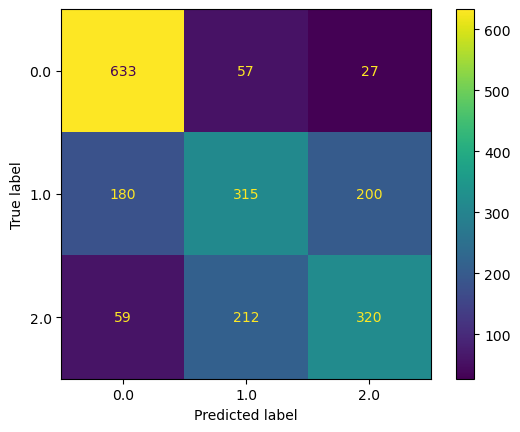

In [42]:
print(classification_report(y_test,y_pred))
plot_confusion_matrix(gridsearch,X_test,y_test);

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team
player_age = X_test.Age

X_train.drop(['player','pick','year','team','Age'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team','Age'],axis=1,inplace=True)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes('float64')

smote = SMOTE(random_state=42)
over_samp = RandomOverSampler(random_state=42)
under_samp = RandomUnderSampler(random_state=42)

cat_transformer = iPipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = iPipeline(steps=[
    ('ss',StandardScaler()),
    ('impute',SimpleImputer(strategy='constant'))])

transformer = ColumnTransformer(transformers=[
    ('num', num_transformer, X_train_num.columns),
    ('cat', cat_transformer, X_train_cat.columns)])

knn_pipe = iPipeline(steps=([
    ('trans',transformer),
    #('smote',smote),
    #('over_samp',over_samp),
    #('under_samp',under_samp),
    ('sample',None),
    ('knn',KNeighborsClassifier())
]))

grid = {
    'knn__n_neighbors':[16,17,18],
    'knn__p':[1],
    'knn__leaf_size':[10,9],
    'knn__algorithm':['ball_tree','auto','kd_tree'],
    'sample':[over_samp,smote]
}

gridsearch = GridSearchCV(estimator=knn_pipe,
                         param_grid=grid,
                         cv=5)

gridsearch.fit(X_train,y_train)

y_pred = gridsearch.predict(X_test)

gridsearch.best_params_

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts a

C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts a

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts a

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\U

{'knn__algorithm': 'ball_tree',
 'knn__leaf_size': 10,
 'knn__n_neighbors': 17,
 'knn__p': 1,
 'sample': RandomOverSampler(random_state=42)}

              precision    recall  f1-score   support

         0.0       0.58      0.86      0.69       717
         1.0       0.46      0.31      0.37       695
         2.0       0.58      0.45      0.51       591

    accuracy                           0.55      2003
   macro avg       0.54      0.54      0.52      2003
weighted avg       0.54      0.55      0.53      2003



C:\Users\capta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and 

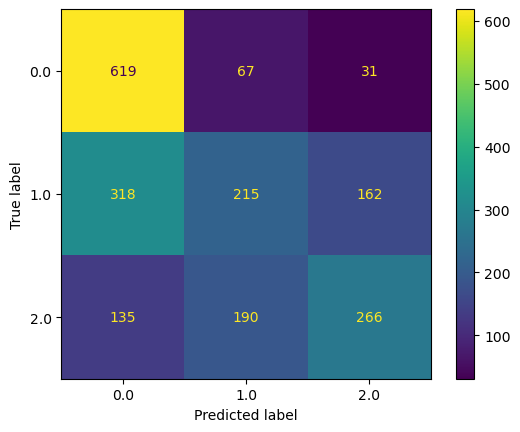

In [7]:
print(classification_report(y_test,y_pred))
plot_confusion_matrix(gridsearch,X_test,y_test)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team
player_age = X_test.Age

X_train.drop(['player','pick','year','team','Age'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team','Age'],axis=1,inplace=True)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes('float64')

smote = SMOTE(random_state=42)
over_samp = RandomOverSampler(random_state=42)
under_samp = RandomUnderSampler(random_state=42)

cat_transformer = iPipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = iPipeline(steps=[
    ('ss',StandardScaler()),
    ('impute',SimpleImputer(strategy='constant'))])

transformer = ColumnTransformer(transformers=[
    ('num', num_transformer, X_train_num.columns),
    ('cat', cat_transformer, X_train_cat.columns)])

xgb_pipe = iPipeline(steps=([
    ('trans',transformer),
    #('smote',smote),
    #('over_samp',over_samp),
    #('under_samp',under_samp),
    ('sample',None),
    ('xgb',xgb.XGBClassifier(random_state=42))
]))

# Set up grid parameters
grid = {"xgb__gamma": [15,20,25],
        "xgb__learning_rate": [0.005, 0.01, 0.05],
        "xgb__max_depth": [3,4,5],
        "xgb__min_child_weight": [1,2],
        "xgb__n_estimators": [25,30,35],
        "sample": [smote,over_samp]
       }

gridsearch = GridSearchCV(estimator=xgb_pipe,
                         param_grid=grid,
                         cv=5)

gridsearch.fit(X_train,y_train)

y_pred = gridsearch.predict(X_test)

gridsearch.best_params_

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

{'sample': RandomOverSampler(random_state=42),
 'xgb__gamma': 20,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 4,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 30}

              precision    recall  f1-score   support

         0.0       0.65      0.97      0.78       717
         1.0       0.53      0.38      0.44       695
         2.0       0.53      0.39      0.45       591

    accuracy                           0.60      2003
   macro avg       0.57      0.58      0.56      2003
weighted avg       0.57      0.60      0.57      2003



C:\Users\capta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


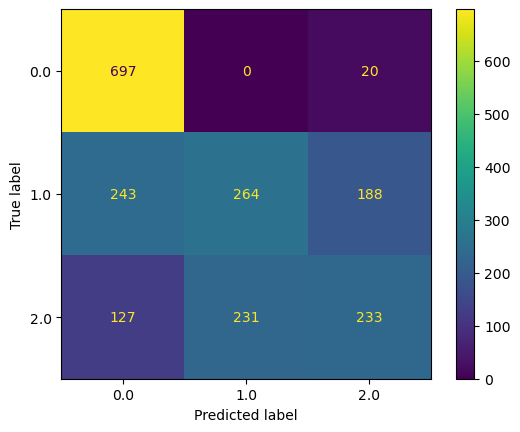

In [11]:
print(classification_report(y_test,y_pred))
plot_confusion_matrix(gridsearch,X_test,y_test)